# Single Microburst Artifitial Neural Network (ANN)
To identify single microbursts in the SAMPEX 20 ms data. The training data comes from the microbursts identified with the O'Brien et al.'s, 2003 burst parameter.

In [1]:
import pathlib

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import progressbar

import microburst_ann.config as config
import microburst_ann.misc.load_hilt_data as load_hilt_data

## Load data
Specify train and test data paths

In [2]:
train_path = pathlib.Path(config.PROJECT_DIR, 'data', 'train.csv')
test_path = pathlib.Path(config.PROJECT_DIR, 'data', 'test.csv')

In [3]:
# Load the csv files
train_df = pd.read_csv(train_path, index_col=0)
test_df = pd.read_csv(test_path, index_col=0)
# Drop the NaN rows
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
# Pop off the training and test labels and make them into their own pd.DataFrames
train_labels = train_df.pop('label')
test_labels = test_df.pop('label')

## Visualize the microburst and nonmicrobursts

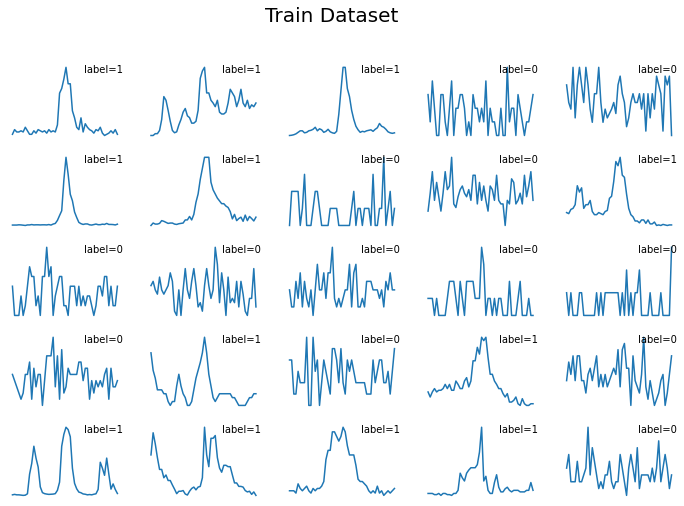

In [7]:
plot_n = (5,5)
rand_idx = np.random.randint(0, train_df.shape[0], size=plot_n)
fig, ax = plt.subplots(nrows=plot_n[0], ncols=plot_n[1], figsize=(12,8))

for i, ax_row in enumerate(ax):
    for j, ax_i in enumerate(ax_row):
        ax_i.plot(train_df.iloc[rand_idx[i,j]])
        ax_i.text(1, 1, f'label={train_labels.iloc[rand_idx[i,j]]}', 
                    va='top', ha='right', transform=ax_i.transAxes)
        ax_i.axis('off')
plt.suptitle('Train Dataset', fontsize=20);

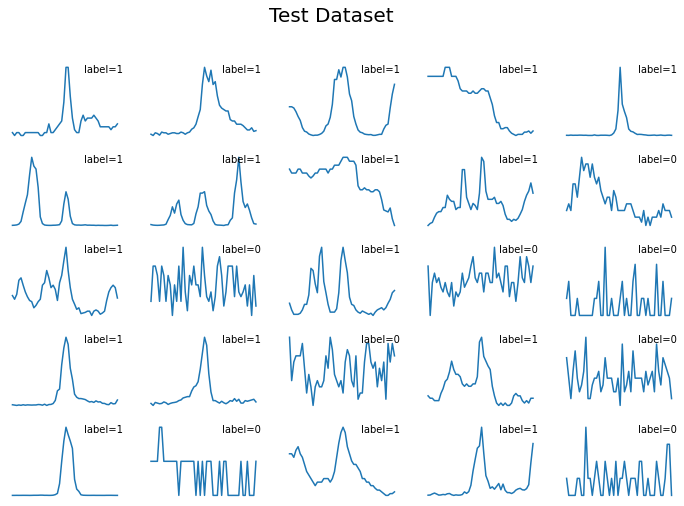

In [8]:
plot_n = (5,5)
rand_idx = np.random.randint(0, test_df.shape[0], size=plot_n)
fig, ax = plt.subplots(nrows=plot_n[0], ncols=plot_n[1], figsize=(12,8))

for i, ax_row in enumerate(ax):
    for j, ax_i in enumerate(ax_row):
        ax_i.plot(test_df.iloc[rand_idx[i,j]])
        ax_i.text(1, 1, f'label={test_labels.iloc[rand_idx[i,j]]}', 
                    va='top', ha='right', transform=ax_i.transAxes)
        ax_i.axis('off')
plt.suptitle('Test Dataset', fontsize=20);

## pd.DataFrame -> tf.Dataset
This streamlines the data input into Tensorflow and Karas. Now sure what else this is good for.

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_df.to_numpy(), train_labels.to_numpy())
    )
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_df.to_numpy(), test_labels.to_numpy())
    )
shuffled_train_dataset = train_dataset.shuffle(train_df.shape[0]).batch(1)

In [9]:
def create_ann_model():
    """ 
    Specify the ANN model architecture and compile it.
    """
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(50,)),
        tf.keras.layers.Dense(25, activation='relu'),
        tf.keras.layers.Dense(25, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

In [7]:
model = create_ann_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                260       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 2,196
Trainable params: 2,196
Non-trainable params: 0
______________________________________________________

So we have 1546 parameters to train. And now lets set up the checkpoint directory to save the model parameters to a binary (h5) file.

In [7]:
checkpoint_path = config.PROJECT_DIR / 'ann' / 'model' / 'model.cp'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1
    )

In [26]:
if True:
    history = model.fit(shuffled_train_dataset, # Normally, you would indicate the data and labels. However, the tf.Dataset takes care of the input.
                        validation_data=(test_df.to_numpy(), test_labels), # Test dataset used to calculate the model accuracy.
                        epochs=3, # How many epochs to use (train using the entire train dataset epoch times.)
                        callbacks=[checkpoint_callback]) # Set up the callback to save the model.

Epoch 1/3
112623/112628 [============================>.] - ETA: 0s - loss: 0.5087 - accuracy: 0.9865
Epoch 00001: saving model to /Users/mshumko/Documents/research/sampex/microburst_ann/microburst_ann/ann/model/model.cp
112628/112628 [==============================] - 297s 3ms/step - loss: 0.5087 - accuracy: 0.9865 - val_loss: 0.5063 - val_accuracy: 0.9911
Epoch 2/3
112622/112628 [============================>.] - ETA: 0s - loss: 0.5055 - accuracy: 0.9921
Epoch 00002: saving model to /Users/mshumko/Documents/research/sampex/microburst_ann/microburst_ann/ann/model/model.cp
112628/112628 [==============================] - 354s 3ms/step - loss: 0.5055 - accuracy: 0.9921 - val_loss: 0.5059 - val_accuracy: 0.9917
Epoch 3/3
112628/112628 [==============================] - ETA: 0s - loss: 0.5055 - accuracy: 0.9926
Epoch 00003: saving model to /Users/mshumko/Documents/research/sampex/microburst_ann/microburst_ann/ann/model/model.cp
112628/112628 [==============================] - 265s 2ms/step

Now to practice the checkpoint API, lets load the trained weights into a new model and set its weights

In [10]:
model2 = create_ann_model()
model2.load_weights(checkpoint_path)

## Evaluate the model

The model.evaluate line below is the same as this handwritten loop:

In [11]:
# n_correct=0
# for i in range(test_df.shape[0]):
#     if round(model(test_df.iloc[i].to_numpy().reshape((1, 50))).numpy()[0][0]) == test_labels.iloc[i]:
#         n_correct += 1
# print(f'n_correct={n_correct}, n_correct/n_total={n_correct/test_df.shape[0]}')

In [11]:
model2.evaluate(test_df.to_numpy(), test_labels, verbose=2)

NameError: name 'test_df' is not defined

*** model.evaluate is optimized so it is MUCH quicker. ***

We got a 99.5% accuracy. Nice!

## Model accuracy and loss functions 
plots as a function of Epoch

In [29]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.ylim(0, 1) # set the vertical range to [0-1]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(0.0, 1.0)

Looks like this problem was too easy for the ANN. We only needed one epoch!

## Confusion Matrix

In [87]:
predicted_label = -1*np.ones(test_df.shape[0])

for i in range(test_df.shape[0]):
    predicted_label[i] = model2(
        test_df.iloc[i].to_numpy().reshape((1, 50))).numpy()[0][0]

In [88]:
index = pd.MultiIndex.from_tuples([('real_label', 'nonmicroburst'), ('real_label', 'microburst')])
columns = pd.MultiIndex.from_tuples([('predicted_label', 'nonmicroburst'), ('predicted_label', 'microburst')])
confusion = pd.DataFrame(data=tf.math.confusion_matrix(test_labels, predicted_label, num_classes=2).numpy(), 
            index=index, columns=columns)
confusion

predicted_label           
                           nonmicroburst microburst
real_label nonmicroburst           13910         89
           microburst                 97      14056

Looks like this model predicts the microburst and nonmicroburst classes very well.

- There are 59 false-positive events (type 1 error): the number of predicted microbursts but were not really a microburst (perhaps those are the few times when the burst parameter missed a true microburst)
- There are 159 false-negative events (type 2 error): the number of true microbursts misidentified as nonmicrobursts.

Lets diagnose this model further.

## ROC and AUC
For this model how to we determine the optimal detection threshold to balance the false positive and the true positive detections? We can use the Receiver Operating Characteristic (ROC) curve to find the optimal threshold that balances this, and we can numerically find out how good the model does by estimating the area under the curve (AUC) statistic

In [89]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(test_labels, predicted_label)
auc = sklearn.metrics.auc(fpr, tpr)

In [90]:
%matplotlib widget
s = plt.scatter(fpr, tpr, c=thresholds)
plt.text(1, 1, f'auc={round(auc, 3)}', ha='right', va='top')
plt.colorbar(s)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Visual inspection
Lets pick a day with lots of microbursts, run the ANN on 1-second window, and plot the output activation as a function of time

In [2]:
load_date = '1999-8-17'
time_limits = ['1999-08-17T03:59:00', '1999-08-17T04:05:00']
hilt = load_hilt_data.Load_SAMPEX_HILT(load_date)
hilt.resolve_counts_state4()
hilt.hilt_resolved = hilt.hilt_resolved.loc[time_limits[0]:time_limits[1], :]

In [3]:
hilt.hilt_resolved

,counts
1999-08-17 03:59:00.000,5.0
1999-08-17 03:59:00.020,4.0
1999-08-17 03:59:00.040,5.0
1999-08-17 03:59:00.060,4.0
1999-08-17 03:59:00.080,4.0
...,...
1999-08-17 04:05:00.900,3.0
1999-08-17 04:05:00.920,3.0
1999-08-17 04:05:00.940,4.0
1999-08-17 04:05:00.960,5.0


Evaluate the model on this day.

In [81]:
validation_labels = np.nan*np.ones(hilt.hilt_resolved.shape[0])

for i in range(0, validation_labels.shape[0]-50):
    c = hilt.hilt_resolved.to_numpy()[i:i+50].copy().reshape((1, 50))
    c -= np.mean(c)
    c /= np.std(c)
    validation_labels[i+25] = model2(c).numpy()[0][0]

In [75]:
i=3900
x = hilt.hilt_resolved.to_numpy()[i:i+50].copy().reshape((1, 50))
x -= np.mean(x)
x /= np.std(x)
print(model2(x))
%matplotlib widget
plt.plot(x.flatten())

tf.Tensor([[1.]], shape=(1, 1), dtype=float32)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [79]:
hilt.hilt_resolved.iloc[2950:4010]

,counts
1999-08-17 03:59:59.000,6.0
1999-08-17 03:59:59.020,6.0
1999-08-17 03:59:59.040,2.0
1999-08-17 03:59:59.060,4.0
1999-08-17 03:59:59.080,9.0
...,...
1999-08-17 04:00:20.100,344.0
1999-08-17 04:00:20.120,204.0
1999-08-17 04:00:20.140,148.0
1999-08-17 04:00:20.160,74.0


In [82]:
%matplotlib widget
max_i = 1000000
fig, bx = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[3, 1]})
bx[0].plot(hilt.hilt_resolved.iloc[:maox_i].index, hilt.hilt_resolved.iloc[:max_i].counts.to_numpy(), 'k')
bx[1].plot(hilt.hilt_resolved.iloc[:max_i].index, validation_labels[:max_i], 'ko')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([5., 4., 5., ..., 4., 5., 1.])